# Text Classification using  Naive Bayes
### Based on IMDB dataset

Another source : https://web.stanford.edu/~jurafsky/slp3/slides/7_NB.pdf

In [156]:
import numpy as np
import pandas as pd
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import glob
import seaborn as sns

from matplotlib import rcParams
sns.set(font_scale=1.35)
rcParams['figure.figsize'] = 8,6

In [157]:
pos_list=glob.glob(pathname="./data/movie-reviews-en/train/pos/*.txt")
neg_list=glob.glob(pathname="./data/movie-reviews-en/train/neg/*.txt")

In [158]:
len(pos_list),len(neg_list)

(900, 900)

In [159]:
n_word = 10000    #Nb of words to keep in the vocabulary

In [160]:
# Function to get all text files as a list of string
def get_text_list(file_list):
    text_list = []
    
    for file in file_list:
        
        with open(file,'r') as f:
            text_list.append(f.read())
            
    return(text_list)
        
pos_text = ' '.join(get_text_list(pos_list))
neg_text = ' '.join(get_text_list(neg_list))

### Small Preprocessing

Remove punctuation and line escape char '\n'

Then we only keep the n_word most occuring word across all text

In [161]:
pos_text = pos_text.translate(str.maketrans('','', string.punctuation))
pos_text = pos_text.replace('\n','')
pos_count = dict(Counter(pos_text.split()).most_common(n_word))

neg_text = neg_text.translate(str.maketrans('','', string.punctuation))
neg_text = neg_text.replace('\n','')
neg_count = dict(Counter(neg_text.split()).most_common(n_word))

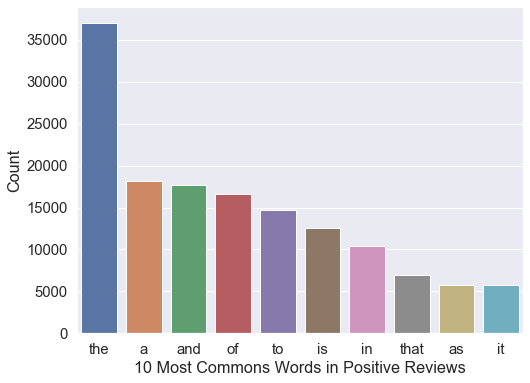

In [162]:
keys = list(pos_count.keys())[0:10]
vals = [float(pos_count[k]) for k in keys]
bp = sns.barplot(x=keys, y=vals)
bp = bp.set(xlabel = '10 Most Commons Words in Positive Reviews', ylabel = 'Count')

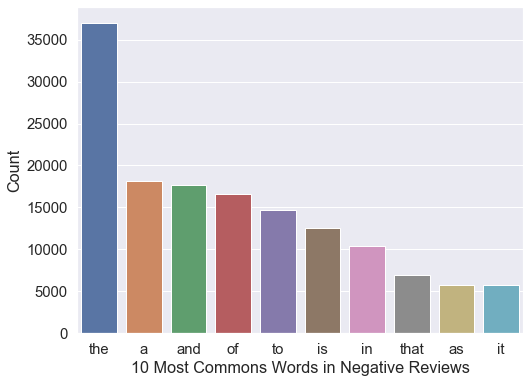

In [163]:
keys = list(pos_count.keys())[0:10]
vals = [float(pos_count[k]) for k in keys]
sns.barplot(x=keys, y=vals)
bp = sns.barplot(x=keys, y=vals)
bp = bp.set(xlabel = '10 Most Commons Words in Negative Reviews', ylabel = 'Count')

In [164]:
df = pd.DataFrame(list((z[0],z[1],"POS")for z in pos_count.items()),columns=['word','count','class'])

In [165]:
df = df.append(pd.DataFrame(list((z[0],z[1],"NEG")for z in neg_count.items()),columns=['word','count','class']))

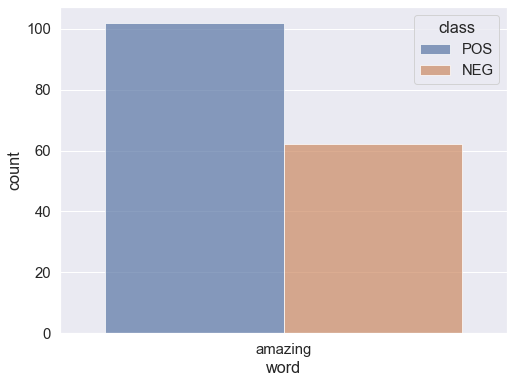

In [166]:
sns.barplot(x='word',y='count',hue='class',data=df[df['word'] == 'amazing'],alpha=0.7)

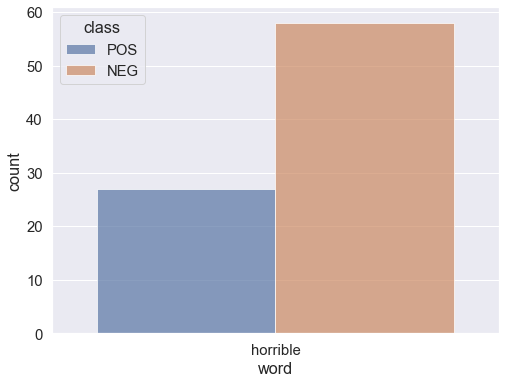

In [167]:
sns.barplot(x='word',y='count',hue='class',data=df[df['word'] == 'horrible'],alpha=0.7)

### Probability functions

In [168]:
#Return the probabilty to have the input word knowing the class
#P(wi|Cj)
#P('nice'|Positive)
# With Laplace Smoothing

def proba_word(word,counter):    
    
    try: 
        
        # If the word is in our Vocabulary
        r = (counter[word]+1)/(sum(counter.values())+len(counter))
        
    except KeyError:
        # Else counter[word] = 0 
        r = (1)/(sum(counter.values())+len(counter))
        
    return(np.float64(r))

In [169]:
#Compute the sum of the log probabilities of each word in the input text

def proba_text(text,counter):   
    
    probs=[]
    
    for word in list(set(text.split())):
        probs.append(np.log(proba_word(word,counter)))
        
    return(np.sum(probs))

### Building our model

In [170]:
def NBmodel(text_array,counter):
    
    predictions = []
    neg_count,pos_count = counter
    
    for text in text_array:
        
        probs = [proba_text(text,neg_count),proba_text(text,pos_count)]
        predictions.append(np.argmax(probs))
        
    return(predictions)

### Testing on the test set

In [171]:
pos_test_list = glob.glob(pathname="./data/movie-reviews-en/test/pos/*.txt")
neg_test_list = glob.glob(pathname="./data/movie-reviews-en/test/neg/*.txt")

In [172]:
pos_test_text = get_text_list(pos_test_list)      
neg_test_text = get_text_list(neg_test_list)

In [173]:
for i in range(0,len(pos_test_text)):
    pos_test_text[i] = pos_test_text[i].translate(str.maketrans('','', string.punctuation))
    pos_test_text[i] = pos_test_text[i].replace('\n','')

for i in range(0,len(neg_test_text)):
    neg_test_text[i] = neg_test_text[i].translate(str.maketrans('','', string.punctuation))
    neg_test_text[i] = neg_test_text[i].replace('\n','')

In [174]:
pos_results = NBmodel(pos_test_text,[neg_count,pos_count])
neg_results = NBmodel(neg_test_text,[neg_count,pos_count])

In [175]:
f" Negative Accuracy : {(len(neg_results)-np.sum(neg_results))/(len(neg_results))} "

' Negative Accuracy : 0.95 '

In [176]:
f"Positive Accuracy : {np.sum(pos_results)/(len(pos_results))}"

'Positive Accuracy : 0.7'

In [177]:
TP = np.sum(pos_results)
TN = len(neg_results)-np.sum(neg_results)
FP = len(pos_results)-np.sum(pos_results)
FN = np.sum(neg_results)

z = np.array([[TP,FP],[FN,TN]])
z

array([[70, 30],
       [ 5, 95]], dtype=int64)

In [178]:
f"Global Accuracy : {(TP+TN)/(TP+TN+FP+FN)}"

'Global Accuracy : 0.825'

### Now with a bit of Preprocessing

Removing stop words using ntlk package

In [179]:
import nltk
from nltk.corpus import stopwords
import re 
stopwords = stopwords.words('english')

for word in stopwords:
    pos_text = re.sub(' '+ word+' ',' ',pos_text)
    neg_text = re.sub(' '+ word+' ',' ',neg_text)


In [180]:
stopwords[0:5]

['i', 'me', 'my', 'myself', 'we']

In [181]:
pos_count = dict(Counter(pos_text.split()).most_common(n_word))
neg_count = dict(Counter(neg_text.split()).most_common(n_word))

In [182]:
for word in stopwords:
    for i in range(0,len(pos_test_text)):
        pos_test_text[i] = re.sub(' '+ word+' ',' ',pos_test_text[i])
        neg_test_text[i] = re.sub(' '+ word+' ',' ',neg_test_text[i])

Accuracy

In [183]:
neg_results = NBmodel(neg_test_text,[neg_count,pos_count])
f"Negative Accuracy : {(len(neg_results)-np.sum(neg_results))/(len(neg_results))}"

'Negative Accuracy : 0.9'

In [184]:
pos_results = NBmodel(pos_test_text,[neg_count,pos_count])
f"Positive Accuracy : {np.sum(pos_results)/(len(pos_results))}"

'Positive Accuracy : 0.73'

Confusion Matrix

In [185]:
TP = np.sum(pos_results)
TN = len(neg_results)-np.sum(neg_results)
FP = len(pos_results)-np.sum(pos_results)
FN = np.sum(neg_results)

z = np.array([[TP,FP],[FN,TN]])
z

array([[73, 27],
       [10, 90]], dtype=int64)

In [186]:
f"Global Accuracy : {(TP+TN)/(TP+TN+FP+FN)}"

'Global Accuracy : 0.815'

### Testing Stemmer

Testing nltk english stemmer

Restart from scratch because we have removed stop words

In [187]:
from nltk.stem.snowball import SnowballStemmer

pos_list=glob.glob(pathname="./data/movie-reviews-en/train/pos/*.txt")
neg_list=glob.glob(pathname="./data/movie-reviews-en/train/neg/*.txt")

pos_text = ' '.join(get_text_list(pos_list))
neg_text = ' '.join(get_text_list(neg_list))

pos_text = pos_text.translate(str.maketrans('','', string.punctuation))
pos_text = pos_text.replace('\n','')

neg_text = neg_text.translate(str.maketrans('','', string.punctuation))
neg_text = neg_text.replace('\n','')

stem_pos_text = []
stem_neg_text = []
EnglishSnowballStemmer = SnowballStemmer("english")

for w in pos_text.split():
    
    if w != ' ':
        stemword = EnglishSnowballStemmer.stem(w)
        stem_pos_text.append(stemword)
        
for w in neg_text.split():
    
    if w != ' ':
        stemword = EnglishSnowballStemmer.stem(w)
        stem_neg_text.append(stemword)
        

In [188]:
stem_pos_count = dict(Counter(stem_pos_text).most_common(n_word))
stem_neg_count = dict(Counter(stem_neg_text).most_common(n_word))

In [189]:
pos_test_list = glob.glob(pathname="./data/movie-reviews-en/test/pos/*.txt")
neg_test_list = glob.glob(pathname="./data/movie-reviews-en/test/neg/*.txt")

pos_test_text = get_text_list(pos_test_list)      
neg_test_text = get_text_list(neg_test_list)

Using the english snowball stemmer

In [190]:
for i in range(0,len(pos_test_text)):
    pos_test_text[i] = pos_test_text[i].translate(str.maketrans('','', string.punctuation))
    pos_test_text[i] = pos_test_text[i].replace('\n','')
    pos_test_text[i] = ' '.join(EnglishSnowballStemmer.stem(w) for w in pos_test_text[i].split())

for i in range(0,len(neg_test_text)):
    neg_test_text[i] = neg_test_text[i].translate(str.maketrans('','', string.punctuation))
    neg_test_text[i] = neg_test_text[i].replace('\n','')
    neg_test_text[i] = ' '.join(EnglishSnowballStemmer.stem(w) for w in neg_test_text[i].split())


Accuracy

In [191]:
pos_results = NBmodel(pos_test_text,[stem_neg_count,stem_pos_count])
neg_results = NBmodel(neg_test_text,[stem_neg_count,stem_pos_count])

print(f"Negative Accuracy : {(len(neg_results)-np.sum(neg_results))/(len(neg_results))}")
print(f"Positive Accuracy : {np.sum(pos_results)/(len(pos_results))}")

Negative Accuracy : 0.92
Positive Accuracy : 0.73


Confusion matrix

In [192]:
TP = np.sum(pos_results)
TN = len(neg_results)-np.sum(neg_results)
FP = len(pos_results)-np.sum(pos_results)
FN = np.sum(neg_results)

z = np.array([[TP,FP],[FN,TN]])
z

array([[73, 27],
       [ 8, 92]], dtype=int64)

In [193]:
f"Global Accuracy : {(TP+TN)/(TP+TN+FP+FN)}"

'Global Accuracy : 0.825'

### Lemmer

In [194]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

pos_list=glob.glob(pathname="./data/movie-reviews-en/train/pos/*.txt")
neg_list=glob.glob(pathname="./data/movie-reviews-en/train/neg/*.txt")

pos_text = ' '.join(get_text_list(pos_list))
neg_text = ' '.join(get_text_list(neg_list))

pos_text = pos_text.translate(str.maketrans('','', string.punctuation))
pos_text = pos_text.replace('\n','')

neg_text = neg_text.translate(str.maketrans('','', string.punctuation))
neg_text = neg_text.replace('\n','')

lemm_pos_text = []
lemm_neg_text = []

wordnet_lemmatizer = WordNetLemmatizer()
tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}


def get_lemma(w):
    tag = nltk.pos_tag([w])[0][1][0].upper()
    lemmword = wordnet_lemmatizer.lemmatize(w,tag_dict.get(tag,wordnet.NOUN))
    return(lemmword)

for w in pos_text.split():
    
    if w != ' ':
        lemm_pos_text.append(get_lemma(w))
        
for w in neg_text.split():
    
    if w != ' ':
        lemm_neg_text.append(get_lemma(w))

In [195]:
lemm_pos_count = dict(Counter(lemm_pos_text).most_common(n_word))
lemm_neg_count = dict(Counter(lemm_neg_text).most_common(n_word))

In [196]:
pos_test_list = glob.glob(pathname="./data/movie-reviews-en/test/pos/*.txt")
neg_test_list = glob.glob(pathname="./data/movie-reviews-en/test/neg/*.txt")

pos_test_text = get_text_list(pos_test_list)      
neg_test_text = get_text_list(neg_test_list)

In [197]:
for i in range(0,len(pos_test_text)):
    pos_test_text[i] = pos_test_text[i].translate(str.maketrans('','', string.punctuation))
    pos_test_text[i] = pos_test_text[i].replace('\n','')
    pos_test_text[i] = ' '.join(get_lemma(w) for w in pos_test_text[i].split())

for i in range(0,len(neg_test_text)):
    neg_test_text[i] = neg_test_text[i].translate(str.maketrans('','', string.punctuation))
    neg_test_text[i] = neg_test_text[i].replace('\n','')
    neg_test_text[i] = ' '.join(get_lemma(w) for w in neg_test_text[i].split())

In [198]:
pos_results = NBmodel(pos_test_text,[lemm_neg_count,lemm_pos_count])
neg_results = NBmodel(neg_test_text,[lemm_neg_count,lemm_pos_count])

print(f"Negative Accuracy : {(len(neg_results)-np.sum(neg_results))/(len(neg_results))}")
print(f"Positive Accuracy : {np.sum(pos_results)/(len(pos_results))}")

Negative Accuracy : 0.91
Positive Accuracy : 0.77


In [199]:
TP = np.sum(pos_results)
TN = len(neg_results)-np.sum(neg_results)
FP = len(pos_results)-np.sum(pos_results)
FN = np.sum(neg_results)

z = np.array([[TP,FP],[FN,TN]])
z

array([[77, 23],
       [ 9, 91]], dtype=int64)

In [200]:
f"Global Accuracy : {(TP+TN)/(TP+TN+FP+FN)}"

'Global Accuracy : 0.84'